In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import glob

def load_training_data(data_dir, num_samples=80):
    """
    Load MRI slices and masks from .h5 files
    Returns: images array, masks array
    """
    image_list = []
    mask_list = []
    
    # Get all .h5 files
    files = glob.glob(f'{data_dir}/*.h5')[:num_samples]
    
    for file_path in files:
        with h5py.File(file_path, 'r') as f:
            image = f['image'][:]
            mask = f['mask'][:]
            
            # Only keep slices with tumor (optional but recommended)
            if np.sum(mask > 0) > 100:  # At least 100 tumor pixels
                image_list.append(image)
                mask_list.append(mask)
    
    images = np.array(image_list)
    masks = np.array(mask_list)
    
    # Normalize images to [0, 1]
    images = (images - images.min()) / (images.max() - images.min() + 1e-8)
    
    # Convert masks to binary (0 or 1)
    masks = (masks > 0).astype(np.float32)
    
    return images, masks

# Load data
data_dir = './data/BraTS/BraTS2020_training_data/content/data'
X, y = load_training_data(data_dir, num_samples=100)

print(f"Loaded {len(X)} slices")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

Loaded 44 slices
Image shape: (44, 240, 240, 4)
Mask shape: (44, 240, 240, 3)


In [3]:
# Train/Val split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training: {len(X_train)} slices")
print(f"Validation: {len(X_val)} slices")

Training: 35 slices
Validation: 9 slices


In [4]:
# 1. Set seeds at the very top
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 2. Train/Val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training: {len(X_train)} slices")
print(f"Validation: {len(X_val)} slices")

# 3. Calculate class weights
tumor_pixels = np.sum(y_train)
background_pixels = y_train.size - tumor_pixels
weight_for_tumor = background_pixels / tumor_pixels
print(f"Tumor weight: {weight_for_tumor:.2f}")

# 4. Build model
def build_unet(input_shape=(240, 240, 4)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c5)
    
    return models.Model(inputs, outputs)

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create augmentation generator
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

model = build_unet()

# 5. Define metrics and loss
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# 6. Compile with dice loss and lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=dice_loss,
    metrics=[dice_coef]
)

# 7. Create sample weights
sample_weights = np.ones(y_train.shape)  # (samples, height, width)
sample_weights[y_train[..., 0] == 1] = weight_for_tumor  # Weight tumor pixels

# 8. Train with sample weights
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=15, mode='max', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_dice_coef', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    sample_weight=sample_weights,
    epochs=100,
    batch_size=4,
    callbacks=callbacks,
    verbose=1
)

Training: 35 slices
Validation: 9 slices
Tumor weight: 113.35
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - dice_coef: 0.0186 - loss: 1.6271

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - dice_coef: 0.0174 - loss: 1.5655 - val_dice_coef: 0.0218 - val_loss: 0.9828
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - dice_coef: 0.0187 - loss: 1.6269

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - dice_coef: 0.0176 - loss: 1.5652 - val_dice_coef: 0.0221 - val_loss: 0.9826
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - dice_coef: 0.0190 - loss: 1.6263

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - dice_coef: 0.0180 - loss: 1.5644 - val_dice_coef: 0.0230 - val_loss: 0.9818
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - dice_coef: 0.0201 - loss: 1.6242

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - dice_coef: 0.0196 - loss: 1.5616 - val_dice_coef: 0.0264 - val_loss: 0.9789
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - dice_coef: 0.0240 - loss: 1.6170

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - dice_coef: 0.0240 - loss: 1.5540 - val_dice_coef: 0.0329 - val_loss: 0.9738
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - dice_coef: 0.0294 - loss: 1.6066

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - dice_coef: 0.0276 - loss: 1.5476 - val_dice_coef: 0.0342 - val_loss: 0.9728
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - dice_coef: 0.0302 - loss: 1.6050

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - dice_coef: 0.0284 - loss: 1.5460 - val_dice_coef: 0.0355 - val_loss: 0.9716
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - dice_coef: 0.0320 - loss: 1.6017

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - dice_coef: 0.0307 - loss: 1.5421 - val_dice_coef: 0.0388 - val_loss: 0.9680
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - dice_coef: 0.0362 - loss: 1.5939

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - dice_coef: 0.0344 - loss: 1.5358 - val_dice_coef: 0.0461 - val_loss: 0.9623
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - dice_coef: 0.0441 - loss: 1.5792

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - dice_coef: 0.0471 - loss: 1.5136 - val_dice_coef: 0.0704 - val_loss: 0.9372
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - dice_coef: 0.0805 - loss: 1.5133

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - dice_coef: 0.1018 - loss: 1.4201 - val_dice_coef: 0.1725 - val_loss: 0.8196
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - dice_coef: 0.2106 - loss: 1.2805

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - dice_coef: 0.1978 - loss: 1.2605 - val_dice_coef: 0.3245 - val_loss: 0.6874
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - dice_coef: 0.3038 - loss: 1.1267

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - dice_coef: 0.2701 - loss: 1.1324 - val_dice_coef: 0.3857 - val_loss: 0.6015
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - dice_coef: 0.3243 - loss: 1.0390 - val_dice_coef: 0.3505 - val_loss: 0.6205
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - dice_coef: 0.3916 - loss: 0.9884

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - dice_coef: 0.3800 - loss: 0.9686 - val_dice_coef: 0.4005 - val_loss: 0.5843
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - dice_coef: 0.3979 - loss: 0.9379 - val_dice_coef: 0.3944 - val_loss: 0.5780
Epoch 17/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - dice_coef: 0.4376 - loss: 0.9193

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 544ms/step - dice_coef: 0.4077 - loss: 0.9266 - val_dice_coef: 0.4239 - val_loss: 0.5618
Epoch 18/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - dice_coef: 0.4432 - loss: 0.9079

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - dice_coef: 0.4192 - loss: 0.9111 - val_dice_coef: 0.4334 - val_loss: 0.5502
Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - dice_coef: 0.4255 - loss: 0.9010 - val_dice_coef: 0.4163 - val_loss: 0.5580
Epoch 20/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - dice_coef: 0.4266 - loss: 0.8998 - val_dice_coef: 0.4324 - val_loss: 0.5552
Epoch 21/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - dice_coef: 0.4350 - loss: 0.8880 - val_dice_coef: 0.4331 - val_loss: 0.5511
Epoch 22/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - dice_coef: 0.4382 - loss: 0.8835 - val_dice_coef: 0.4144 - val_loss: 0.5630
Epoch 23/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - dice_coef: 0.4326 - loss: 0.8900 - val_dice_coef: 0.4323 - val_loss: 0.5570
Epoch 24/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - dice_coef: 0.4720 - loss: 0.8638

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step - dice_coef: 0.4385 - loss: 0.8829 - val_dice_coef: 0.4349 - val_loss: 0.5458
Epoch 25/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - dice_coef: 0.4870 - loss: 0.8421

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - dice_coef: 0.4426 - loss: 0.8763 - val_dice_coef: 0.4426 - val_loss: 0.5418
Epoch 26/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - dice_coef: 0.4944 - loss: 0.8303

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - dice_coef: 0.4503 - loss: 0.8653 - val_dice_coef: 0.4544 - val_loss: 0.5213
Epoch 27/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - dice_coef: 0.5104 - loss: 0.7945

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - dice_coef: 0.4520 - loss: 0.8563 - val_dice_coef: 0.4589 - val_loss: 0.5202
Epoch 28/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - dice_coef: 0.4629 - loss: 0.8417 - val_dice_coef: 0.4547 - val_loss: 0.5220
Epoch 29/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - dice_coef: 0.4589 - loss: 0.8430 - val_dice_coef: 0.4560 - val_loss: 0.5223
Epoch 30/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - dice_coef: 0.4624 - loss: 0.8376 - val_dice_coef: 0.4555 - val_loss: 0.5213
Epoch 31/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - dice_coef: 0.5176 - loss: 0.7775

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - dice_coef: 0.4609 - loss: 0.8398 - val_dice_coef: 0.4599 - val_loss: 0.5175
Epoch 32/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - dice_coef: 0.4664 - loss: 0.8327 - val_dice_coef: 0.4582 - val_loss: 0.5180
Epoch 33/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - dice_coef: 0.5205 - loss: 0.7741

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - dice_coef: 0.4646 - loss: 0.8355 - val_dice_coef: 0.4614 - val_loss: 0.5155
Epoch 34/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - dice_coef: 0.5248 - loss: 0.7680

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - dice_coef: 0.4694 - loss: 0.8289 - val_dice_coef: 0.4618 - val_loss: 0.5148
Epoch 35/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step - dice_coef: 0.4702 - loss: 0.8279 - val_dice_coef: 0.4608 - val_loss: 0.5156
Epoch 36/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - dice_coef: 0.5212 - loss: 0.7738

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - dice_coef: 0.4681 - loss: 0.8313 - val_dice_coef: 0.4679 - val_loss: 0.5092
Epoch 37/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - dice_coef: 0.5281 - loss: 0.7639

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - dice_coef: 0.4761 - loss: 0.8195 - val_dice_coef: 0.4715 - val_loss: 0.5043
Epoch 38/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - dice_coef: 0.5288 - loss: 0.7630

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - dice_coef: 0.4776 - loss: 0.8174 - val_dice_coef: 0.4791 - val_loss: 0.4963
Epoch 39/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - dice_coef: 0.5334 - loss: 0.7549

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - dice_coef: 0.4817 - loss: 0.8107 - val_dice_coef: 0.4815 - val_loss: 0.4932
Epoch 40/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - dice_coef: 0.4838 - loss: 0.8071 - val_dice_coef: 0.4803 - val_loss: 0.4946
Epoch 41/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - dice_coef: 0.4845 - loss: 0.8060 - val_dice_coef: 0.4796 - val_loss: 0.4958
Epoch 42/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - dice_coef: 0.4853 - loss: 0.8049 - val_dice_coef: 0.4798 - val_loss: 0.4957
Epoch 43/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - dice_coef: 0.4877 - loss: 0.8015 - val_dice_coef: 0.4800 - val_loss: 0.4956
Epoch 44/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step - dice_coef: 0.4909 - loss: 0.7969 - val_dice_coef: 0.4801 - val_loss: 0.4957
Epoch 45/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - dice_coef: 0.4931 - loss: 0.7936 - val_dice_coef: 0.4803 - val_loss: 0.4956
Epoch 46/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 465ms/step - dice_coef: 0.4934 - loss: 0.7928 - val_dice_coef:

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - dice_coef: 0.4988 - loss: 0.7838 - val_dice_coef: 0.4816 - val_loss: 0.4961
Epoch 54/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - dice_coef: 0.5553 - loss: 0.7199

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - dice_coef: 0.5022 - loss: 0.7793 - val_dice_coef: 0.4819 - val_loss: 0.4967
Epoch 55/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - dice_coef: 0.5604 - loss: 0.7129

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - dice_coef: 0.5060 - loss: 0.7739 - val_dice_coef: 0.4821 - val_loss: 0.4971
Epoch 56/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - dice_coef: 0.5624 - loss: 0.7098

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - dice_coef: 0.5069 - loss: 0.7723 - val_dice_coef: 0.4823 - val_loss: 0.4968
Epoch 57/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - dice_coef: 0.5055 - loss: 0.7735 - val_dice_coef: 0.4815 - val_loss: 0.4972
Epoch 58/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - dice_coef: 0.5068 - loss: 0.7721 - val_dice_coef: 0.4819 - val_loss: 0.4975
Epoch 59/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - dice_coef: 0.5664 - loss: 0.7048

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - dice_coef: 0.5106 - loss: 0.7683 - val_dice_coef: 0.4838 - val_loss: 0.4990
Epoch 60/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - dice_coef: 0.5104 - loss: 0.7688 - val_dice_coef: 0.4802 - val_loss: 0.5076
Epoch 61/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - dice_coef: 0.5465 - loss: 0.7282

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - dice_coef: 0.4997 - loss: 0.7801 - val_dice_coef: 0.4879 - val_loss: 0.5002
Epoch 62/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - dice_coef: 0.5563 - loss: 0.7154

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - dice_coef: 0.5087 - loss: 0.7691 - val_dice_coef: 0.5036 - val_loss: 0.4743
Epoch 63/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - dice_coef: 0.5145 - loss: 0.7593 - val_dice_coef: 0.4985 - val_loss: 0.4782
Epoch 64/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - dice_coef: 0.5130 - loss: 0.7634 - val_dice_coef: 0.4905 - val_loss: 0.4937
Epoch 65/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - dice_coef: 0.5206 - loss: 0.7525 - val_dice_coef: 0.4855 - val_loss: 0.4970
Epoch 66/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - dice_coef: 0.5246 - loss: 0.7481 - val_dice_coef: 0.4809 - val_loss: 0.5042
Epoch 67/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - dice_coef: 0.5145 - loss: 0.7593 - val_dice_coef: 0.4920 - val_loss: 0.4932
Epoch 68/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 484ms/step - dice_coef: 0.5261 - loss: 0.7442 - val_dice_coef: 0.4947 - val_loss: 0.4870
Epoch 69/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - dice_coef: 0.5292 - loss: 0.7391 - val_dice_coef:

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - dice_coef: 0.5269 - loss: 0.7433 - val_dice_coef: 0.5059 - val_loss: 0.4724
Epoch 78/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - dice_coef: 0.5369 - loss: 0.7282 - val_dice_coef: 0.4924 - val_loss: 0.4848
Epoch 79/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - dice_coef: 0.5800 - loss: 0.6768

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - dice_coef: 0.5288 - loss: 0.7345 - val_dice_coef: 0.5122 - val_loss: 0.4693
Epoch 80/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - dice_coef: 0.5391 - loss: 0.7239 - val_dice_coef: 0.4909 - val_loss: 0.4953
Epoch 81/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - dice_coef: 0.5450 - loss: 0.7143 - val_dice_coef: 0.4934 - val_loss: 0.4893
Epoch 82/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - dice_coef: 0.5459 - loss: 0.7132 - val_dice_coef: 0.5086 - val_loss: 0.4723
Epoch 83/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - dice_coef: 0.5507 - loss: 0.7053 - val_dice_coef: 0.4605 - val_loss: 0.5345
Epoch 84/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - dice_coef: 0.5427 - loss: 0.7139 - val_dice_coef: 0.4833 - val_loss: 0.5084
Epoch 85/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - dice_coef: 0.5461 - loss: 0.7124 - val_dice_coef: 0.4901 - val_loss: 0.4964
Epoch 86/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - dice_coef: 0.5565 - loss: 0.6981 - val_dice_coef:

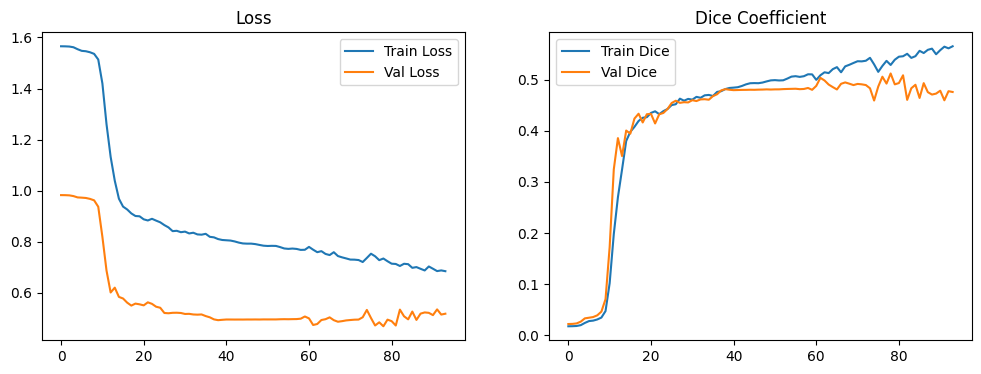

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.legend()
plt.title('Dice Coefficient')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


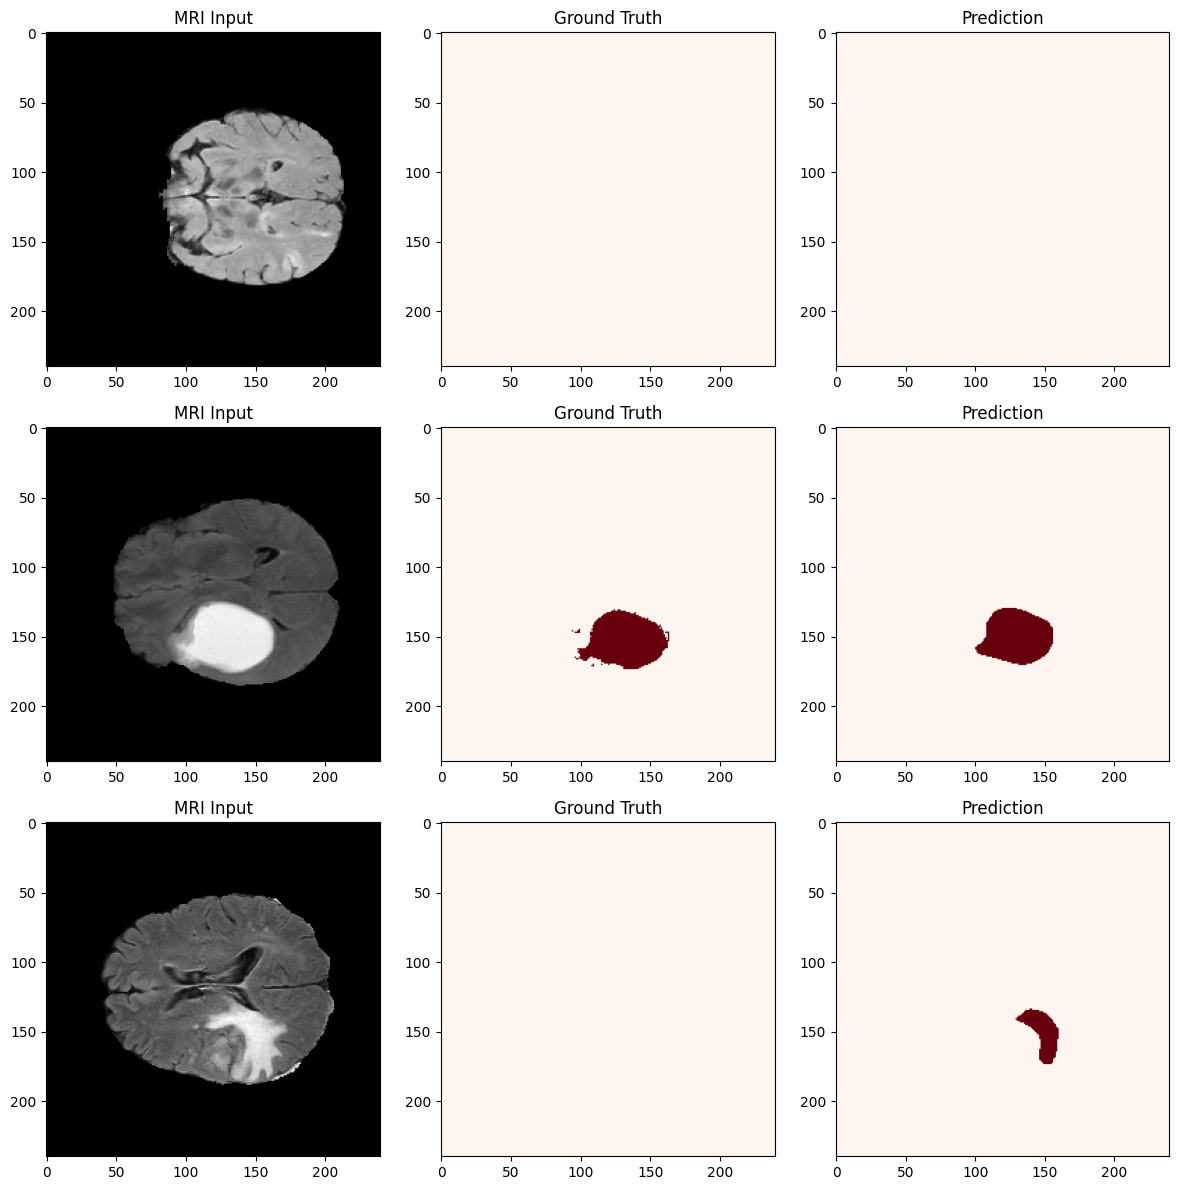

In [6]:
# Predict on validation set
predictions = model.predict(X_val)

# Visualize
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    axes[i, 0].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title('MRI Input')
    
    axes[i, 1].imshow(y_val[i, :, :, 0], cmap='Reds')
    axes[i, 1].set_title('Ground Truth')
    
    axes[i, 2].imshow(predictions[i, :, :, 0] > 0.5, cmap='Reds')
    axes[i, 2].set_title('Prediction')

plt.tight_layout()
plt.show()